In [1]:
import numpy as np
import pandas as pd
import joblib

# Loading preprocessed data
X_scaled = np.load("../../outputs/X_processed.npy")
y = pd.read_csv("../../outputs/y.csv")["SalePrice"].values

In [3]:
# --- Split once and reuse for all models ---
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Model Dictionary ---
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    #'SVR': SVR(kernel='rbf'),
}

# --- Train & Evaluate (Non-SVR models) ---
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)    

    rmse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2 Score": r2})

# --- SVR with y-scaling ---
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

svr = SVR(kernel='rbf')
svr.fit(X_train, y_train_scaled)

y_pred_scaled = svr.predict(X_test)
y_pred_svr = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

mae = mean_absolute_error(y_test, y_pred_svr)
rmse = mean_squared_error(y_test, y_pred_svr)
r2 = r2_score(y_test, y_pred_svr)

results.append({"Model": "SVR (scaled y)", "MAE": mae, "RMSE": rmse, "R2 Score": r2})

# Display results
df_results = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'R2 Score'])
print(df_results.sort_values(by='R2 Score', ascending=False))

               Model           MAE          RMSE      R2 Score
3  Gradient Boosting  7.146089e+02  1.459640e+06  9.997358e-01
2      Random Forest  4.146981e+02  1.746532e+06  9.996838e-01
1      Decision Tree  5.785822e+02  3.411796e+06  9.993823e-01
4     SVR (scaled y)  1.024332e+04  2.447455e+08  9.556920e-01
0  Linear Regression  1.194127e+13  1.640156e+28 -2.969291e+18


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18672\2657589653.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Model", y="RMSE", palette="viridis")
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18672\2657589653.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Model", y="MAE", palette="magma")
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18672\2657589653.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Model", y="R2 Score", palette="crest")


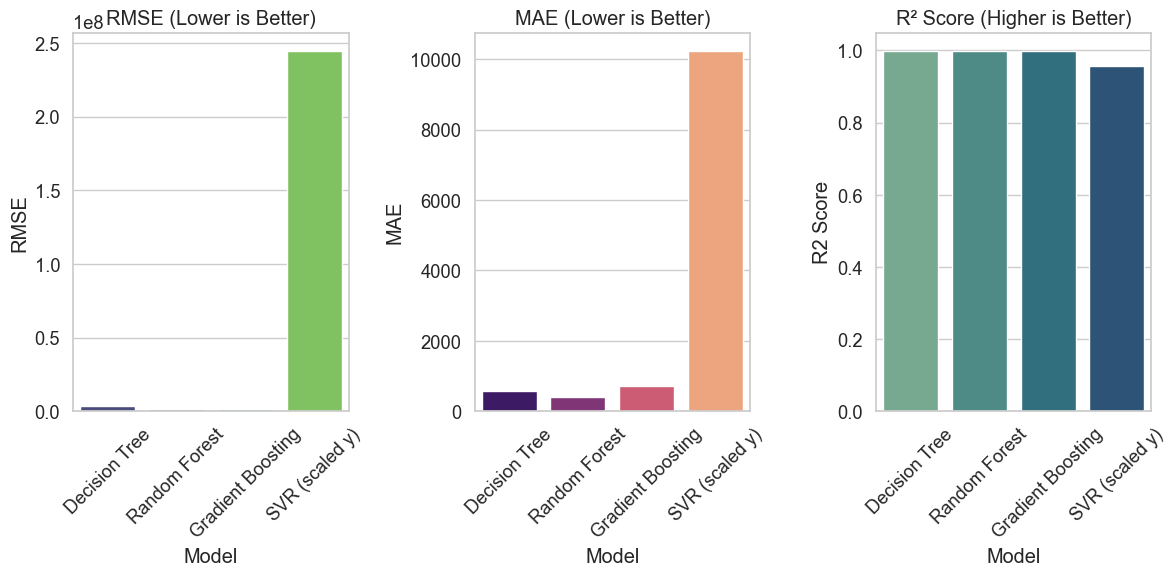

In [93]:
import seaborn as sns
import pandas as pd

df_results = df_results[df_results["Model"] != "Linear Regression"]

# Set style
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(12, 6))

# RMSE Plot
plt.subplot(1, 3, 1)
sns.barplot(data=df_results, x="Model", y="RMSE", palette="viridis")
plt.xticks(rotation=45)
plt.title("RMSE (Lower is Better)")

# MAE Plot
plt.subplot(1, 3, 2)
sns.barplot(data=df_results, x="Model", y="MAE", palette="magma")
plt.xticks(rotation=45)
plt.title("MAE (Lower is Better)")

# R² Plot
plt.subplot(1, 3, 3)
sns.barplot(data=df_results, x="Model", y="R2 Score", palette="crest")
plt.xticks(rotation=45)
plt.title("R² Score (Higher is Better)")

plt.tight_layout()
plt.show()


In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Step 1: Load preprocessed data
X = np.load("../../outputs/X_processed.npy")
y = pd.read_csv("../../outputs/y.csv").values.ravel()  # Flatten target to 1D

# Step 2: Define parameter grids
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10]
}

# Step 3: Grid Search for Random Forest
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=rf_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)
rf_grid.fit(X, y)

# Step 4: Grid Search for Gradient Boosting
gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid=gb_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)
gb_grid.fit(X, y)

# Step 5: Extract and print best results
print("🌲 Random Forest Results")
print("Best Parameters:", rf_grid.best_params_)
print("Best RMSE (CV):", -rf_grid.best_score_)  # Convert negative to positive

print("\n🚀 Gradient Boosting Results")
print("Best Parameters:", gb_grid.best_params_)
print("Best RMSE (CV):", -gb_grid.best_score_)


🌲 Random Forest Results
Best Parameters: {'max_depth': None, 'n_estimators': 200}
Best RMSE (CV): 4217.2861805517405

🚀 Gradient Boosting Results
Best Parameters: {'max_depth': 3, 'n_estimators': 100}
Best RMSE (CV): 2810.9682431403808


In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define parameter grid
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
}

# Perform grid search
grid_search_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='neg_root_mean_squared_error'
)
grid_search_rf.fit(X_train, y_train)

# Get best model and parameters
best_rf = grid_search_rf.best_estimator_
best_params_rf = grid_search_rf.best_params_
print("Best Parameters:", best_params_rf)

# Predict on the test data using the best model
y_pred = best_rf.predict(X_test)

# Evaluate the model
rmse_rf = mean_squared_error(y_test, y_pred, squared=False)
mae_rf = mean_absolute_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)

# Print the results
print("Final Evaluation on Test Set for Random Forest:")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")
print(f"R² Score: {r2_rf:.4f}")

Best Parameters: {'max_depth': 10, 'n_estimators': 200}
Final Evaluation on Test Set for Random Forest:
RMSE: 1154.97
MAE: 362.18
R² Score: 0.9998


C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


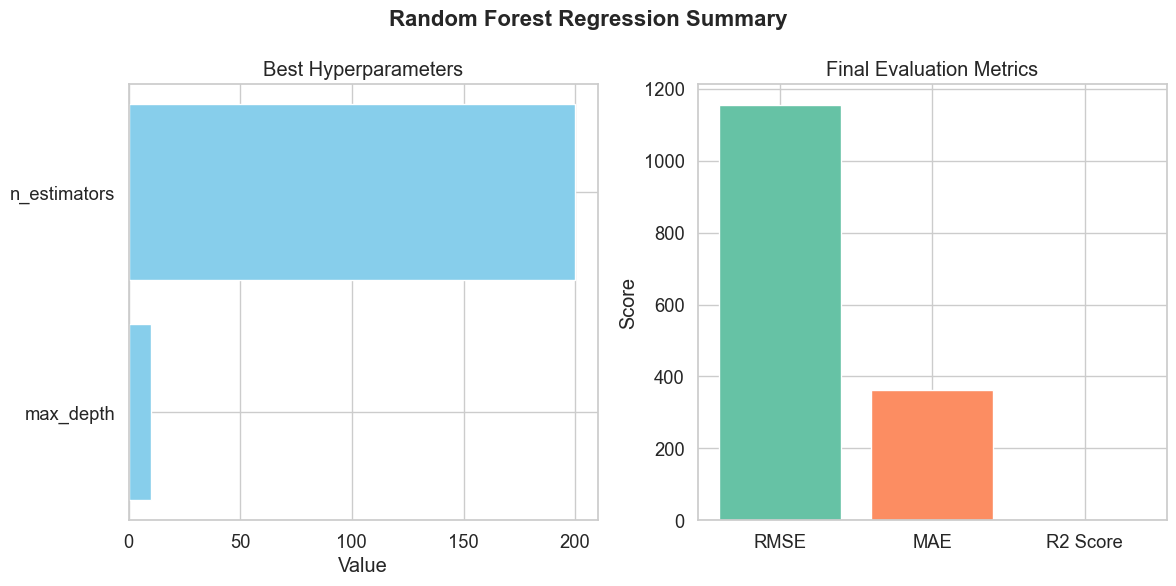

In [97]:
import matplotlib.pyplot as plt

# Convert params to two lists
params = list(best_params_rf.keys())
values = list(best_params_rf.values())

final_scores = {
    "RMSE": rmse_rf,
    "MAE": mae_rf,
    "R2 Score": r2_rf
}

# Bar plot for final metrics
metrics = list(final_scores.keys())
scores = [round(score, 2) for score in final_scores.values()]  # ← rounding here

colors = ['#66c2a5', '#fc8d62', '#8da0cb']  # Define color list

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Random Forest Regression Summary", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leaves space at the top

# Best Hyperparameters
axes[0].barh(params, values, color='skyblue')
axes[0].set_title("Best Hyperparameters")
axes[0].set_xlabel("Value")

# Final Evaluation
axes[1].bar(metrics, scores, color=colors)
axes[1].set_title("Final Evaluation Metrics")
axes[1].set_ylabel("Score")

plt.tight_layout()
plt.show()

In [99]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define parameter grid
param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Perform grid search
grid_search_gbr = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gbr,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_search_gbr.fit(X_train, y_train)

# Get best model and parameters
best_gbr = grid_search_gbr.best_estimator_
best_params_gbr = grid_search_gbr.best_params_
print("Best Parameters:", best_params_gbr)

# Predict on the test data using the best model
y_pred = best_gbr.predict(X_test)

# Evaluate the model
rmse_gbr = mean_squared_error(y_test, y_pred, squared=False)
mae_gbr = mean_absolute_error(y_test, y_pred)
r2_gbr = r2_score(y_test, y_pred)

# Print the results
print("Final Evaluation on Test Set for Gradient Boosting:")
print(f"RMSE: {rmse_gbr:.2f}")
print(f"MAE: {mae_gbr:.2f}")
print(f"R² Score: {r2_gbr:.4f}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
Final Evaluation on Test Set for Gradient Boosting:
RMSE: 1186.13
MAE: 419.06
R² Score: 0.9997


C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


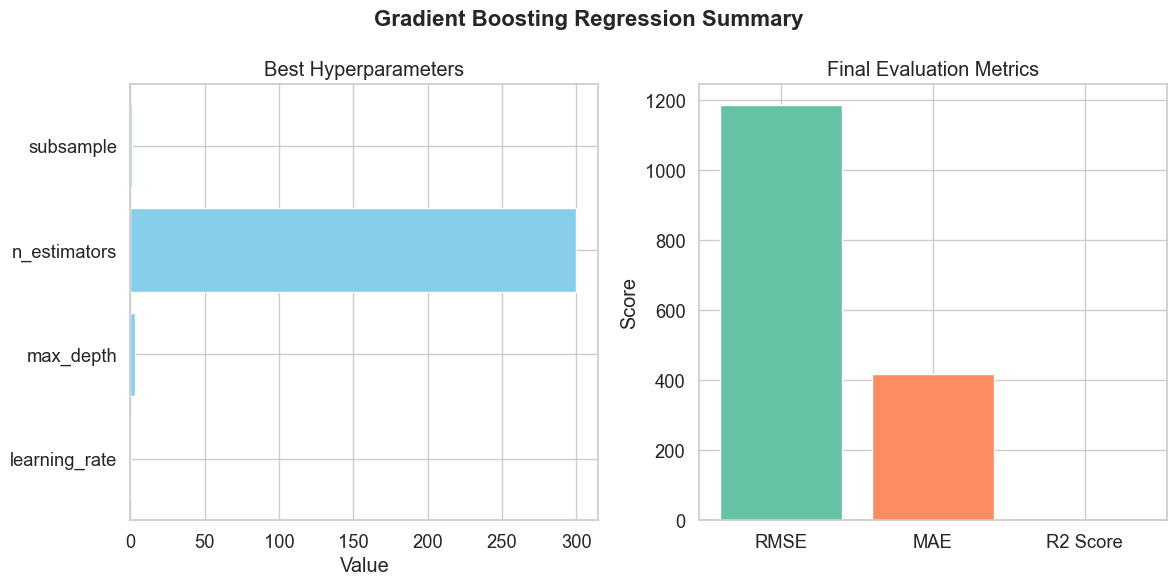

In [101]:
import matplotlib.pyplot as plt

# Convert params to two lists
params = list(best_params_gbr.keys())
values = list(best_params_gbr.values())

final_scores = {
    "RMSE": rmse_gbr,
    "MAE": mae_gbr,
    "R2 Score": r2_gbr
}

# Bar plot for final metrics
metrics = list(final_scores.keys())
scores = [round(score, 2) for score in final_scores.values()]  # ← rounding here

colors = ['#66c2a5', '#fc8d62', '#8da0cb']  # Define color list

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Gradient Boosting Regression Summary", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leaves space at the top

# Best Hyperparameters
axes[0].barh(params, values, color='skyblue')
axes[0].set_title("Best Hyperparameters")
axes[0].set_xlabel("Value")

# Final Evaluation
axes[1].bar(metrics, scores, color=colors)
axes[1].set_title("Final Evaluation Metrics")
axes[1].set_ylabel("Score")

plt.tight_layout()
plt.show()

#### Best-Performing Algorithm: Random Forest Regressor

**<u>Justification:</u>**

    - Comparatevely Higher R2 score (~0.9998) → best at explaining the variance in the data.

    - Lowest RMSE more accurate predictions with fewer large errors.

    - Captures non-linearities and interactions between features that linear models miss.

    - Offers a good balance between bias and variance through boosting.

#### Worst-Performing Algorithm: Linear Regression and SVR
**<u>Reasoning:</u>**

    - Lower R2 score → fails to capture much of the data's variance.

    - Higher error metrics (MSE and MAE) than other models.

    - Assumes a linear relationship, which oversimplifies the complex patterns in housing data (e.g., income, rooms, location all interact in non-linear ways).

#### Summary
Best Model	---> Random Forest Regressor <br>
Why?        ---> Best accuracy, handles complex data relationships <br>
Worst Model ---> Linear Regression and SVR<br>
Why?	    ---> Too simplistic, underfits the data <br>

In [103]:
import joblib

# Save model
joblib.dump(best_rf, "../../models/final_model.pkl")

['../../models/final_model.pkl']